# SVM Project


### 전체 코드 참조
[코드 관련 블로그글](https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=221667083964)

## 0) Basic Package Uploads & Data 파악
+ 사전에 주어진 Bad Datas = 1119, 1905, 2211, 2393, 2442, 2495, 2596, 2603, 2605

In [7]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# Data 확인
data = pd.read_csv('C:/DataScience/data/result.csv', index_col='PERSON_ID')

In [4]:
data.shape

(38495, 30)

In [5]:
data.head()

,AGE_GROUP,BLDS,BP_HIGH,BP_LWST,HEIGHT,TOT_CHOLE,WEIGHT,SEX,PRSC_AGI,PRSC_DPP4I,...,SUB_SICK_HRT,SUB_SICK_HTN,SUB_SICK_HYP,SUB_SICK_KDY,SUB_SICK_LBP,SUB_SICK_LIVER,SUB_SICK_MULTI,SUB_SICK_NEURO,SUB_SICK_STK,Cluster
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
10000755,0.357143,0.15250,0.500000,0.450450,0.784588,0.555789,0.483607,1,0,1,...,0,1,1,0,0,0,0,0,0,0
10002236,0.571429,0.13375,0.400000,0.315315,0.410683,0.294737,0.233607,2,0,0,...,0,1,0,0,0,0,0,0,0,0
10003063,0.642857,0.11200,0.365333,0.291892,0.568827,0.403789,0.367213,2,1,0,...,0,0,0,0,0,0,0,1,0,1
10013228,0.642857,0.14625,0.333333,0.360360,0.674256,0.206316,0.368852,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10043731,1.000000,0.10175,0.502667,0.409009,0.527145,0.333474,0.332787,2,0,0,...,0,1,0,0,0,0,0,0,0,0


## 1) Data Formatting

- 전체 데이터는 클러스터 0,1의 라벨로 나뉘어져있음.
- 클러스터 0과 1의 수 비율은 2:1 정도임. (따라서 오버 샘플링 or 언더 샘플링의 필요성 없음)
- 데이터의 숫자가 4만줄 가까이 되기 때문에 꽤 큰 데이터 사이즈임
    - 따라서 **Large Data Set**에 맞는 기법을 선택해야함
    
    
[Large Dataset SVM Handling에 관련된 글](https://m.blog.naver.com/cjh226/221359032956)

### **먼저 SVM 패키지 함수 생성하기**

In [10]:
# 선형 분리 & 교차검증 결과 function

# 선형
def linear_SVM(X, y) :
    import sklearn.svm as svm
    import sklearn.metrics as mt
    from sklearn.model_selection import cross_val_score, cross_validate

    warnings.filterwarnings(action='ignore')

    # SVM, kernel = 'linear'로 선형분리 진행
    svm_clf =svm.SVC(kernel = 'linear')
    svm_clf
    # 교차검증
    scores = cross_val_score(svm_clf, X, y, cv = None)
    df = pd.DataFrame(cross_validate(svm_clf, X, y, cv =None))
    score_mean = scores.mean()
    return scores, df, score_mean

# 비선형
def rbf_SVM(X, y) :
    import sklearn.svm as svm
    import sklearn.metrics as mt
    from sklearn.model_selection import cross_val_score, cross_validate
    
    warnings.filterwarnings(action='ignore')
    
    # SVM, kernel = 'rbf'로 비선형분리 진행
    svm_clf =svm.SVC(kernel = 'rbf')
    # 교차검증
    scores = cross_val_score(svm_clf, X, y, cv = 5)
    df = pd.DataFrame(cross_validate(svm_clf, X, y, cv = 5))
    score_mean = scores.mean()
    return scores, df, score_mean

### **LinearSVC 관련 패키지 업로드**

In [8]:
import numpy as np
import time
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

## 1. Load data
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
print('X.shape: {}'.format(X.shape))
print('y.shape: {}'.format(y.shape))

## 2. Build estimators
kernel = 'linear'
dual = False if X.shape[0] > X.shape[1] else True

estimator_names = ['SVC', 'LinearSVC', 'Bagging+SVC', 'Bagging+LinearSVC', 'Bagging+SVC+Multiprocess', 'Bagging+LinearSVC+Multiprocess']
estimators = [SVC(kernel=kernel),
			  LinearSVC(dual=dual),
			  BaggingClassifier(SVC(kernel=kernel), n_estimators=10, max_samples=0.1, n_jobs=1),
			  BaggingClassifier(LinearSVC(dual=dual), n_estimators=10, max_samples=0.1, n_jobs=1),
			  BaggingClassifier(SVC(kernel=kernel), n_estimators=10, max_samples=0.1, n_jobs=10),
			  BaggingClassifier(LinearSVC(dual=dual), n_estimators=10, max_samples=0.1, n_jobs=10)]

## 3. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 4. Fit and Prediction
print('Estimator\tAccuracy\tTime')
for name, estimator in zip(estimator_names, estimators):
	start_time = time.time()
	estimator.fit(X_train, y_train)
	score = estimator.score(X_test, y_test) # accuracy
	end_time = time.time()
	print('{}\t{:.3f}\t{:.3f}'.format(name, score, (end_time-start_time)))

X.shape: (38495, 29)
y.shape: (38495,)
Estimator	Accuracy	Time
SVC	0.995	2.781
LinearSVC	0.997	0.103
Bagging+SVC	0.989	1.321
Bagging+LinearSVC	0.995	0.398
Bagging+SVC+Multiprocess	0.989	6.425
Bagging+LinearSVC+Multiprocess	0.994	0.371


### **오버샘플링과 언더샘플링**

In [11]:
from imblearn.over_sampling import *
from imblearn.under_sampling import *

print(" * Over Sampling ")

X_imb = data.iloc[:,:-1]
y_imb = data.iloc[:,-1]

X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_imb, y_imb)

l1, l2, l3 = linear_SVM(X_samp, y_samp)
n1, n2, n3 = rbf_SVM(X_samp, y_samp)

print('선형 분리 결과 교차검증 평균: ', l3)
print('비선형 분리 결과 교차검증 평균: ', n3)

print("\n * Under Sampling ")

X_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(X_imb, y_imb)

l1, l2, l3 = linear_SVM(X_samp, y_samp)
n1, n2, n3 = rbf_SVM(X_samp, y_samp)

print('선형 분리 결과 교차검증 평균: ', l3 )
print('비선형 분리 결과 교차검증 평균: ', n3)

 * Over Sampling 
선형 분리 결과 교차검증 평균:  0.9936618551173698
비선형 분리 결과 교차검증 평균:  0.9890575748623933

 * Under Sampling 
선형 분리 결과 교차검증 평균:  0.9922654601150347
비선형 분리 결과 교차검증 평균:  0.9849694372466946


### **SVC로 해보기(kernel='linear')**

In [12]:
X_imb = data.iloc[:,:-1]
y_imb = data.iloc[:,-1]

# 변환된 X로 데이터 분할 
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, 
                                                      test_size = 0.3,
                                                       random_state = 100)

import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 변환된 X로 교차검증
scores = cross_val_score(svm_clf, X_scaled, y, cv = 5)
scores
pd.DataFrame(cross_validate(svm_clf, X_scaled, y, cv =5))

print('교차검증 평균: ', scores.mean())

선형 분리 결과 교차검증 평균:  0.9964410962462656
비선형 분리 결과 교차검증 평균:  0.9906741135212365


### **LinearSVC로 해보기**

In [40]:
X_imb = data.iloc[:,:-1]
y_imb = data.iloc[:,-1]

# 변환된 X로 데이터 분할 
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, 
                                                      test_size = 0.3,
                                                       random_state = 100)

import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
Lsvm_clf =svm.LinearSVC(random_state=100, max_iter=1000) #기본 Parameters

# 변환된 X로 교차검증
scores = cross_val_score(Lsvm_clf, X_imb, y_imb, cv = 5)
scores
pd.DataFrame(cross_validate(Lsvm_clf, X_imb, y_imb, cv =5))

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.9977659436290427


# 2) Defining SVM parameters
 SVM 파라미터를 튜닝하기 위해서 GridSearchCV를 활용하도록 하겠습니다. 우선 SVM에서 사용하는 주요 파라미터에 대한 설명을 하겠습니다.

+ C(cost) : 이론에서 배운 주요 파라미터로써 어느 정도의 오차를 허용할지에 대한 파라미터입니다.
+ kernel : 어떤 커널함수를 사용할지에 대한 파라미터입니다. 'linear', 'sigmoid', 'rbf', 'poly'가 활용됩니다.
+ degree : 어느 차수까지의 다항차수로 분류를 할 지에 대한 파라미터입니다. 커널함수가 'poly' 일 때 사용됩니다.
+ gamma : 곡률 경계에 대한 파라미터입니다. 'rbf', 'poly', 'sigmoid'일 때 튜닝하는 값입니다.
+ coef0 : 상수값으로써 'poly', 'sigmoid'일 때 튜닝을 진행합니다.

*현재는 선형분리에 대해서 다루기 때문에 C값만 튜닝*

[SVM 패키지 파라미터 관련 링크](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [18]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
Lsvm_clf = Lsvm_clf =svm.LinearSVC(dual=True, tol=0.0001, multi_class='ovr', 
                                   random_state=100, max_iter=1000)

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
             'loss': ['hinge','squared_hinge']}

grid_svm = GridSearchCV(Lsvm_clf,
                        param_grid = parameters, cv = 5)

grid_svm.fit(X_train, y_train)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,C,loss,mean_test_score
9,10.000,squared_hinge,0.998812
13,50.000,squared_hinge,0.998775
11,25.000,squared_hinge,0.998627
10,25.000,hinge,0.998441
15,100.000,squared_hinge,0.998144
12,50.000,hinge,0.997996
8,10.000,hinge,0.997848
14,100.000,hinge,0.997662
7,1.000,squared_hinge,0.997551
6,1.000,hinge,0.995918


([<matplotlib.axis.XTick at 0x2898969e588>,
 <a list of 6 Text xticklabel objects>)

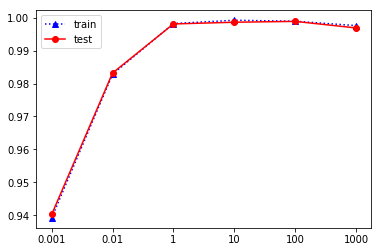

In [21]:
score1 = []
score2 = []
Cs = [0.001, 0.01, 1, 10, 100, 1000]

for C in Cs:
    model = LinearSVC(C=C)
    model.fit(X_train, y_train)
    s1 = model.score(X_train, y_train)
    s2 = model.score(X_test, y_test)
    score1.append(s1)
    score2.append(s2)

plt.plot(score1, 'b^:')
plt.plot(score2, 'ro-')
plt.legend(['train','test'])
plt.xticks(range(len(Cs)), Cs)

# 3) SVM Training Process , 4) Model Validation (Train Data)
+ 앞서 얻은 결과를 바탕으로 Over Sampling을 활용한 선형분리 진행 (파라미터: C=1)

In [43]:
# SVM, kernel = 'linear'로 선형분리 진행
Lsvm_clf = svm.LinearSVC(dual=True, tol=0.0001, multi_class='ovr', 
                                   random_state=100, max_iter=1000,C=10)
Lsvm_clf.fit(X_train, y_train)

# 변환된 X로 교차검증
scores = cross_val_score(Lsvm_clf, X_train, y_train, cv = 5)
print(scores)
print(pd.DataFrame(cross_validate(Lsvm_clf, X_train, y_train, cv = 5)))
print('교차검증 평균: ', scores.mean())

[0.99888683 0.99925775 0.99851549 0.99870106 0.99870106]
   fit_time  score_time  test_score
0  0.100730    0.002993    0.998887
1  0.104721    0.002991    0.999258
2  0.113694    0.004988    0.998515
3  0.111701    0.003990    0.998701
4  0.126661    0.002992    0.998701
교차검증 평균:  0.998812436933477


In [24]:
w = Lsvm_clf.coef_
b = Lsvm_clf.intercept_

display(w, b)

array([[-3.03155346e+01,  4.01453720e+00, -1.60826790e+01,
        -1.06426186e+01,  1.38582695e+00,  2.21162879e+00,
        -1.46836556e+00,  1.76741270e+01,  5.80898695e-02,
         7.37149468e-02,  0.00000000e+00, -1.76758630e+01,
         1.29809436e-02, -4.41568239e-02, -7.56163551e-02,
         3.25066680e-02,  7.85916851e-02, -7.04220159e-02,
         5.84939685e-02,  3.03917148e-02, -5.83785040e-02,
        -1.74851447e+01,  1.74806664e+01,  1.11599732e-01,
         3.46944695e-18, -7.94020112e-02,  7.28140237e-02,
        -4.52794560e-02, -2.10164999e-01]])

array([9.29517165])

In [30]:
print(Lsvm_clf.decision_function(X_train))

[ -2.0999896  -18.45017807 -15.46243959 ... -29.67329736  18.64680307
   7.87891978]


# 5) Prediction
+ 모델 활용하여 test data predict

+ **평가점수**<br>이진 분류평가표로부터 하나의 평가점수(score)를 계산하여 그 값을 최종적인 기준으로 사용하는 경우가 많다.<br>이 때도 관점에 따라 다양한 평가점수가 쓰인다.
    1. **정확도**<br>
    
    정확도(accuracy)는 전체 샘플 중 맞게 예측한 샘플 수의 비율을 뜻한다. 높을수록 좋은 모형이다. 일반적으로 학습에서 최적화 목적함수로 사용된다.
    2. **정밀도**<br>
    
    정밀도(precision)은 양성 클래스에 속한다고 출력한 샘플 중 실제로 양성 클래스에 속하는 샘플 수의 비율을 말한다. 높을수록 좋은 모형이다. FDS의 경우, 사기 거래라고 판단한 거래 중 실제 사기 거래의 비율이 된다.
    3. **재현율**<br>
    
    재현율(recall)은 실제 양성 클래스에 속한 표본 중에 양성 클래스에 속한다고 출력한 표본의 수의 비율을 뜻한다. 높을수록 좋은 모형이다. FDS의 경우 실제 사기 거래 중에서 실제 사기 거래라고 예측한 거래의 비율이 된다. TPR(true positive rate) 또는 민감도(sensitivity)라고도 한다.
    4. **위양성율**<br>
    
    위양성율(fall-out)은 실제 양성 클래스에 속하지 않는 표본 중에 양성 클래스에 속한다고 출력한 표본의 비율을 말한다. 다른 평가점수와 달리 낮을수록 좋은 모형이다. FDS의 경우에는 실제로는 정상 거래인데 FDS가 사기 거래라고 예측한 거래의 비율이 된다. FPR(false positive rate)또는 1에서 위양성률의 값을 뺀 값을 특이도(specificity)라고도 한다.
    
    5. **F점수**<br>
    정밀도와 재현율의 가중조화평균(weight harmonic average)을 F점수(F-score)라고 한다. 정밀도에 주어지는 가중치를 베타(beta)라고 한다.
    
 
**참고** 사이킷런 패키지의 metrics 패키지에서는 정밀도, 재현율, F1점수를 구하는 classification_report 명령을 제공한다. 이 명령은 각각의 클래스를 양성(positive) 클래스로 보았을 때의 정밀도, 재현율, F1점수를 각각 구하고 그 평균값으로 전체 모형의 성능을 평가한다.


[관련 정보 링크](https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/)

[Confusion Matrix 파라미터 링크](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = Lsvm_clf.predict(X_test)

print("<< Classification Report>>\n",classification_report(y_test, y_pred,labels=[0,1], 
                                                           target_names=["0","1"],digits=4))
print('<<Accuracy Score>>\n%.5f' % accuracy_score(y_test, y_pred))

<< Classification Report>>
               precision    recall  f1-score   support

           0     0.9987    0.9992    0.9990      7792
           1     0.9984    0.9973    0.9979      3757

    accuracy                         0.9986     11549
   macro avg     0.9986    0.9983    0.9984     11549
weighted avg     0.9986    0.9986    0.9986     11549

<<Accuracy Score>>
0.99861


# 6) Result representation
+ 고차원 데이터이므로 PCA 진행 후 시각화

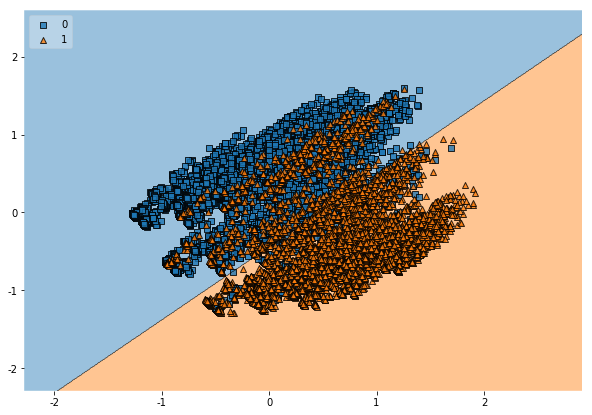

In [20]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

pca_svm = svm.SVC(kernel = 'linear', random_state=0, C=1.0)
pca_svm.fit(X_train_pca, y_train)

y_pred = pca_svm.predict(X_test_pca)

plt.figure(figsize=(10,7))
plot_decision_regions(X_train_pca, np.array(y_train), clf=pca_svm, legend=2)